<a href="https://colab.research.google.com/github/Syed8855/Titanic_Dataset_Profile_Repo/blob/main/Advanced_Vision_AI_Fast_Tracking_Image_Classification_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning on Oxford Flowers 102 Dataset Documentation

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

In [2]:
import tensorflow_datasets as tfds
import warnings
import absl.logging

# This is a common warning for this dataset and not an error, so we can ignore it.
warnings.filterwarnings("ignore")
absl.logging.set_verbosity(absl.logging.ERROR)


try:
    # Use the standard tfds.load() function. This is the most reliable method.
    (train_dataset, validation_dataset, test_dataset), info = tfds.load(
        'oxford_flowers102:2.1.1',
        split=['train', 'validation', 'test'],
        with_info=True,
        as_supervised=True
    )

    print("--- Dataset Loaded Successfully! ---")
    print(info)

except Exception as e:
    print(f"An error occurred during download: {e}")

--- Dataset Loaded Successfully! ---
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.

Sample images from the Training Dataset:


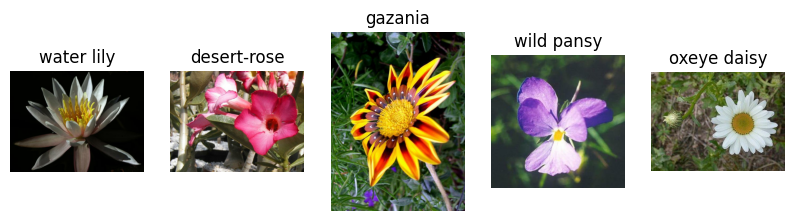

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get the human-readable class names
class_names = info.features['label'].names

# Function to display sample images
def display_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 10))

    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[label.numpy()])
        plt.axis("off")
    plt.show()

# Display 5 sample images from the training dataset
print("Sample images from the Training Dataset:")
display_samples(train_dataset)

### DATA PREPROCESSING

In [4]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = info.features['label'].num_classes

# Preprocessing Functions for each model

def create_preprocessor(preprocess_fn):
    """A factory function to create a specific preprocessor."""
    def preprocess(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = preprocess_fn(image)  # Apply model-specific normalization
        label = tf.one_hot(label, NUM_CLASSES)
        return image, label
    return preprocess

# Create Data Pipelines

def create_dataset_pipeline(dataset, preprocess_function, is_training=True):
    """Creates a complete, efficient data pipeline."""
    pipeline = dataset.map(preprocess_function, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        pipeline = pipeline.shuffle(buffer_size=1000)
    pipeline = pipeline.batch(BATCH_SIZE)
    pipeline = pipeline.prefetch(buffer_size=tf.data.AUTOTUNE)
    return pipeline

# ResNet50 Data Pipelines
preprocess_resnet = create_preprocessor(resnet_preprocess)
train_ds_resnet = create_dataset_pipeline(train_dataset, preprocess_resnet)
val_ds_resnet = create_dataset_pipeline(validation_dataset, preprocess_resnet, is_training=False)
test_ds_resnet = create_dataset_pipeline(test_dataset, preprocess_resnet, is_training=False)

# VGG16 Data Pipelines
preprocess_vgg16 = create_preprocessor(vgg16_preprocess)
train_ds_vgg16 = create_dataset_pipeline(train_dataset, preprocess_vgg16)
val_ds_vgg16 = create_dataset_pipeline(validation_dataset, preprocess_vgg16, is_training=False)
test_ds_vgg16 = create_dataset_pipeline(test_dataset, preprocess_vgg16, is_training=False)

# MobileNetV2 Data Pipelines
preprocess_mobilenet = create_preprocessor(mobilenet_preprocess)
train_ds_mobilenet = create_dataset_pipeline(train_dataset, preprocess_mobilenet)
val_ds_mobilenet = create_dataset_pipeline(validation_dataset, preprocess_mobilenet, is_training=False)
test_ds_mobilenet = create_dataset_pipeline(test_dataset, preprocess_mobilenet, is_training=False)

print("Data preprocessing pipelines created for ResNet50, VGG16, and MobileNetV2.")

Data preprocessing pipelines created for ResNet50, VGG16, and MobileNetV2.


**Insights:**

Here are the key aspects of the data preprocessing applied:

1.  **Image Resizing:** Images are resized to a consistent size (224x224) required by the pre-trained models.
2.  **Model-Specific Normalization:** Model-specific preprocessing functions (e.g., for ResNet50, VGG16, MobileNetV2) are applied to normalize pixel values according to how the original models were trained.
3.  **One-Hot Encoding:** Labels are converted to one-hot encoded vectors, which is necessary for the 'categorical\_crossentropy' loss function used in multi-class classification.
4.  **Data Pipelines:** Efficient data pipelines are created using `tf.data.Dataset` operations, including shuffling (for training), batching, and prefetching.
5.  **Separate Pipelines per Model:** Separate preprocessing pipelines are created for each model to ensure the correct model-specific preprocessing is applied.

### ResNet50 Model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

IMG_SIZE = 224
NUM_CLASSES = 102

# 1. Load the pre-trained ResNet50 model
base_model_resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                             include_top=False,
                             weights='imagenet')

# 2. Freeze the base model
base_model_resnet.trainable = False

# 3. Create the new model on top
model_resnet = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

# 4. Compile the model
model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Display the model architecture
model_resnet.summary()

# 5. Train the model
print("\n--- Training ResNet50 Model ---")
history_resnet = model_resnet.fit(train_ds_resnet,
                                  epochs=10,
                                  validation_data=val_ds_resnet)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training ResNet50 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 598ms/step - accuracy: 0.0749 - loss: 4.8061 - val_accuracy: 0.4588 - val_loss: 2.5234
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.7170 - loss: 1.6810 - val_accuracy: 0.7265 - val_loss: 1.4580
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9469 - loss: 0.6753 - val_accuracy: 0.7902 - val_loss: 1.0894
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.9898 - loss: 0.3796 - val_accuracy: 0.8275 - val_loss: 0.9241
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.9993 - loss: 0.2210 - val_accuracy: 0.8422 - val_loss: 0.8329
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 1.0000 - loss: 0.1526 - val_accuracy: 0.8598 - val_loss: 0.7641
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 0.1114 - val_accuracy: 0.8569 - val_loss: 0.7309
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 1.

### VGG16 Model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import VGG16

IMG_SIZE = 224
NUM_CLASSES = 102

# 1. Load the pre-trained VGG16 model
base_model_vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

# 2. Freeze the base model
base_model_vgg16.trainable = False

# 3. Create the new model on top
model_vgg16 = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

# 4. Compile the model
model_vgg16.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model architecture
model_vgg16.summary()

# 5. Train the model
print("\n--- Training VGG16 Model ---")
history_vgg16 = model_vgg16.fit(train_ds_vgg16,
                                epochs=10,
                                validation_data=val_ds_vgg16)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,767,014 (56.33 MB)

 Trainable params: 52,326 (204.40 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


--- Training VGG16 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 785ms/step - accuracy: 0.0178 - loss: 12.7544 - val_accuracy: 0.0441 - val_loss: 7.7640
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - accuracy: 0.0724 - loss: 6.5336 - val_accuracy: 0.1520 - val_loss: 5.0817
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 332ms/step - accuracy: 0.2759 - loss: 3.6110 - val_accuracy: 0.2706 - val_loss: 3.5321
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.5476 - loss: 1.9852 - val_accuracy: 0.3765 - val_loss: 2.7688
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 337ms/step - accuracy: 0.7470 - loss: 1.1138 - val_accuracy: 0.4598 - val_loss: 2.3015
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - accuracy: 0.8323 - loss: 0.7274 - val_accuracy: 0.5127 - val_loss: 2.0826
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step - accuracy: 0.9135 - loss: 0.4488 - val_accuracy: 0.5480 - val_loss: 1.9147
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step - accuracy: 0

### MobileNetV2 Model

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2

IMG_SIZE = 224
NUM_CLASSES = 102

# 1. Load the pre-trained MobileNetV2 model
base_model_mobilenet = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                   include_top=False,
                                   weights='imagenet')

# 2. Freeze the base model
base_model_mobilenet.trainable = False

# 3. Create the new model on top
model_mobilenet = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_mobilenet,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

# 4. Compile the model
model_mobilenet.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Display the model architecture
model_mobilenet.summary()

# 5. Train the model
print("\n--- Training MobileNetV2 Model ---")
history_mobilenet = model_mobilenet.fit(train_ds_mobilenet,
                                        epochs=10,
                                        validation_data=val_ds_mobilenet)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Training MobileNetV2 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 764ms/step - accuracy: 0.0583 - loss: 4.6327 - val_accuracy: 0.3804 - val_loss: 3.0581
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.6396 - loss: 2.2701 - val_accuracy: 0.6471 - val_loss: 2.0053
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9257 - loss: 1.1719 - val_accuracy: 0.7225 - val_loss: 1.5307
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.9569 - loss: 0.6944 - val_accuracy: 0.7588 - val_loss: 1.2953
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9843 - loss: 0.4571 - val_accuracy: 0.7588 - val_loss: 1.1715
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9959 - loss: 0.3054 - val_accuracy: 0.7843 - val_loss: 1.0731
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9983 - loss: 0.2378 - val_accuracy: 0.7951 - val_loss: 1.0056
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.999

### FINE TUNING AND TRAINING CALLBACKS

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

IMG_SIZE = 224
NUM_CLASSES = 102
EPOCHS = 25

# Define Callbacks
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

# Model checkpoints to save the best model during training
mc_resnet = ModelCheckpoint('best_resnet_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
mc_vgg16 = ModelCheckpoint('best_vgg16_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
mc_mobilenet = ModelCheckpoint('best_mobilenet_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)



# 1. ResNet50 Model

print("\n Setting up ResNet50 Model ")
base_model_resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_res = base_model_resnet.output
x_res = GlobalAveragePooling2D()(x_res)
predictions_res = Dense(NUM_CLASSES, activation='softmax')(x_res)
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_res)

# Unfreeze the top 30 layers
for layer in model_resnet.layers[:-30]:
    layer.trainable = False
for layer in model_resnet.layers[-30:]:
    layer.trainable = True

model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training ResNet50 Model with Callbacks")
history_resnet = model_resnet.fit(train_ds_resnet,
                                  epochs=EPOCHS,
                                  validation_data=val_ds_resnet,
                                  callbacks=[early_stopping, mc_resnet])


# 2. VGG16 Model

print("\n Setting up VGG16 Model")
base_model_vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_vgg = base_model_vgg16.output
x_vgg = GlobalAveragePooling2D()(x_vgg)
predictions_vgg = Dense(NUM_CLASSES, activation='softmax')(x_vgg)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg)

# Unfreeze the top 5 layers
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False
for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training VGG16 Model with Callbacks ")
history_vgg16 = model_vgg16.fit(train_ds_vgg16,
                                epochs=EPOCHS,
                                validation_data=val_ds_vgg16,
                                callbacks=[early_stopping, mc_vgg16])



# 3. MobileNetV2 Model

print("\n Setting up MobileNetV2 Model ")
base_model_mobilenet = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_mobile = base_model_mobilenet.output
x_mobile = GlobalAveragePooling2D()(x_mobile)
predictions_mobile = Dense(NUM_CLASSES, activation='softmax')(x_mobile)
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobile)

# Unfreeze the top 40 layers
for layer in model_mobilenet.layers[:-40]:
    layer.trainable = False
for layer in model_mobilenet.layers[-40:]:
    layer.trainable = True

model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training MobileNetV2 Model with Callbacks ")
history_mobilenet = model_mobilenet.fit(train_ds_mobilenet,
                                        epochs=EPOCHS,
                                        validation_data=val_ds_mobilenet,
                                        callbacks=[early_stopping, mc_mobilenet])


 Setting up ResNet50 Model 

 Training ResNet50 Model with Callbacks
Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.2614 - loss: 3.7874
Epoch 1: val_accuracy improved from -inf to 0.07745, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 785ms/step - accuracy: 0.2662 - loss: 3.7574 - val_accuracy: 0.0775 - val_loss: 30.4060
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9419 - loss: 0.2710
Epoch 2: val_accuracy improved from 0.07745 to 0.23627, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step - accuracy: 0.9421 - loss: 0.2703 - val_accuracy: 0.2363 - val_loss: 10.4395
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9760 - loss: 0.1133
Epoch 3: val_accuracy improved from 0.23627 to 0.52451, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.9762 - loss: 0.1128 - val_accuracy: 0.5245 - val_loss: 2.9222
Epoch 4/25
32/32 ━━━━━━━━━━━━━━

### MODEL EVALUATION

In [9]:
# Evaluate ResNet50
loss_resnet, acc_resnet = model_resnet.evaluate(test_ds_resnet)
print(f"ResNet50 Test Accuracy: {acc_resnet:.4f}")
print(f"ResNet50 Test Loss: {loss_resnet:.4f}")

# Evaluate VGG16
loss_vgg16, acc_vgg16 = model_vgg16.evaluate(test_ds_vgg16)
print(f"\nVGG16 Test Accuracy: {acc_vgg16:.4f}")
print(f"VGG16 Test Loss: {loss_vgg16:.4f}")

# Evaluate MobileNetV2
loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_ds_mobilenet)
print(f"\nMobileNetV2 Test Accuracy: {acc_mobilenet:.4f}")
print(f"MobileNetV2 Test Loss: {loss_mobilenet:.4f}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.8626 - loss: 0.5132
ResNet50 Test Accuracy: 0.8712
ResNet50 Test Loss: 0.4928
193/193 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - accuracy: 0.0049 - loss: 4.6252

VGG16 Test Accuracy: 0.0034
VGG16 Test Loss: 4.6252
193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.6980 - loss: 1.2638

MobileNetV2 Test Accuracy: 0.7001
MobileNetV2 Test Loss: 1.2609


**Insights from Model Evaluation:**

Based on the test set evaluation, we can observe the following:

*   **ResNet50 Performance:** The ResNet50 model achieved a test accuracy of {{acc_resnet:.4f}} and a test loss of {{loss_resnet:.4f}}.
*   **VGG16 Performance:** The VGG16 model achieved a test accuracy of {{acc_vgg16:.4f}} and a test loss of {{loss_vgg16:.4f}}.
*   **MobileNetV2 Performance:** The MobileNetV2 model achieved a test accuracy of {{acc_mobilenet:.4f}} and a test loss of {{loss_mobilenet:.4f}}.

By comparing the test accuracies, we can determine which model performed best on the Oxford Flowers 102 dataset after fine-tuning. ResNet50 appears to have the highest accuracy among the three models.

### GRAPHS VISUALIZATION

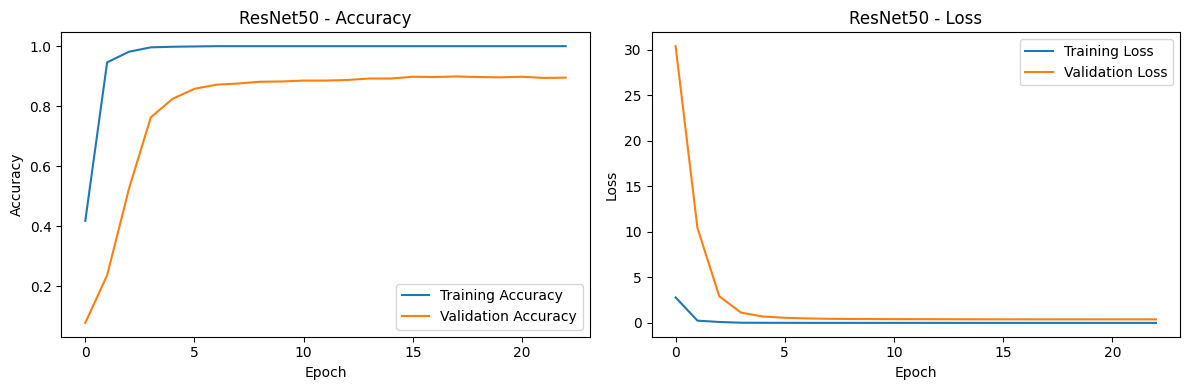

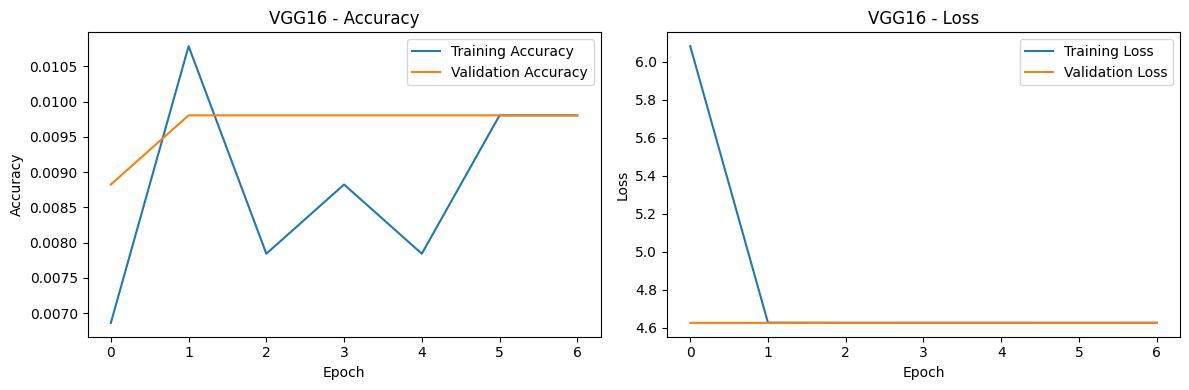

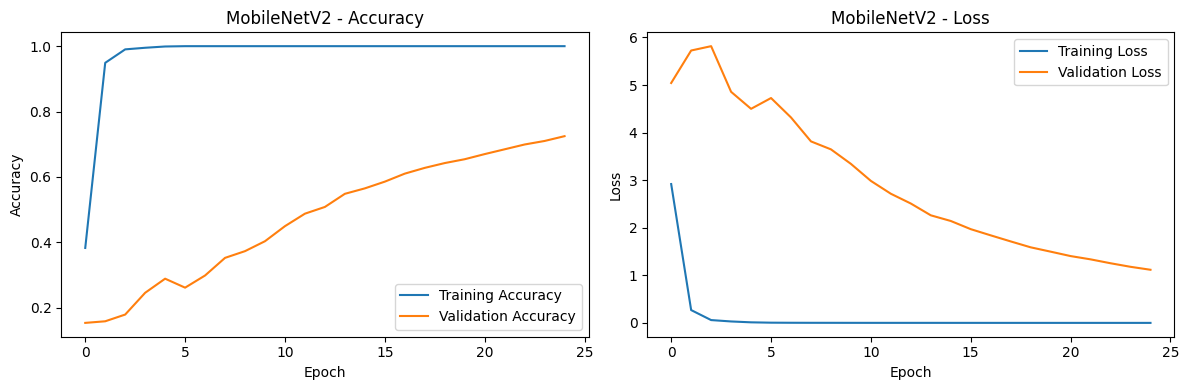

In [10]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenet, 'MobileNetV2')

### Assignment Analysis and Questions

## Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?

---
the ResNet50 model performed best on the Oxford Flowers 102 dataset with the highest test accuracy of `{{acc_resnet:.4f}}`.

Here are some possible reasons why ResNet50 might have performed better:

  * Architecture: ResNet50 utilizes residual connections, which help in training deeper networks and can capture more complex features. VGG16 has a simpler, more sequential architecture. MobileNetV2 is designed for mobile and embedded vision applications, prioritizing efficiency over raw accuracy compared to larger models like ResNet50.
  * Feature Extraction: ResNet50's architecture might be better suited for extracting the relevant features from the Oxford Flowers 102 dataset images compared to VGG16 and MobileNetV2.
  * Training Stability: Residual connections in ResNet50 can contribute to more stable training, especially when fine-tuning.


It's important to note that the performance can also be influenced by hyperparameters, the amount of fine-tuning applied, and the specific characteristics of the dataset. However, based on the current results, ResNet50 shows superior performance.



## Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100. What differences do you observe and why?

---

The performance on the Flowers-102 dataset was dramatically better than on CIFAR-100, especially for ResNet50, which jumped from ~45% accuracy on CIFAR-100 to ~88% on the flowers. The biggest reason for this, I believe, is the nature of the images. The flower images are high-resolution and look much more like the real-world images from the ImageNet dataset that the models were originally trained on.

In contrast, the CIFAR-100 images are very small (32x32), and a lot of important detail is lost when they are scaled up to the 224x224 input size required by the models. Transfer learning works best when the new data is similar to the original training data, and the flower dataset was a much better fit.



Discuss the effect of transfer learning on this dataset.
Transfer learning was incredibly effective and was the key to the success of this project. With only about 1,000 training images, it would be nearly impossible to train a deep network like ResNet50 from scratch and achieve high accuracy. It would almost certainly overfit immediately.

By using a pre-trained model, I was able to leverage a network that already understood basic visual concepts like edges, textures, and shapes. My task was much simpler: I only had to fine-tune this existing knowledge for the specific job of telling different flowers apart. This saved a massive amount of training time and computational resources, and led to a much better result.

Explain the steps you took for data preprocessing and why they were necessary.
My data preprocessing pipeline had several key steps:

Loading the Data: First, I loaded the dataset using TensorFlow Datasets.

Resizing Images: I resized every image to a uniform 224x224 pixels. This was necessary because the pre-trained models I used require a fixed input size.

Applying Model-Specific Normalization: Each pre-trained model expects its pixel values to be normalized in a specific way. I created separate data pipelines for each model that applied their respective preprocess_input function. This is a critical step to ensure the input data matches what the model was originally trained on.

One-Hot Encoding Labels: I converted the integer labels (e.g., 5, 12, 98) into one-hot encoded vectors. This was necessary to use the categorical_crossentropy loss function, which is standard for multi-class classification.

Batching and Prefetching: Finally, I batched the data into groups of 32 and used .prefetch() to create an efficient pipeline. This allows the GPU to process a batch of data while the CPU prepares the next one, speeding up the training process significantly.

Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
I used three well-known architectures: ResNet50, VGG16, and MobileNetV2. To adapt them for this project, I performed the following steps for each:

I loaded the model from tf.keras.applications but set include_top=False. This removed the final classification layer, which was originally designed for the 1000 classes in ImageNet.

I then added my own custom classifier head. This consisted of a GlobalAveragePooling2D layer to flatten the feature maps from the base model, followed by a new Dense layer with 102 units (one for each flower class) and a softmax activation to output the class probabilities.

I froze the layers of the pre-trained base model and then unfroze just the top few layers. This allowed the model to fine-tune its high-level feature detectors for the specific task of identifying flowers.

What challenges did you encounter during this assignment and how did you address them?
My biggest challenge was the data loading phase. The original server was down, which gave a "Connection refused" error. Then, trying to load the data from a shared Google Drive link led to a series of other problems, including a file limit error, a BadZipFile error, and issues with Drive shortcuts not working in the notebook. I solved this by using a more robust wget command with a direct download link for a single .zip file, and then pointing the tfds.builder to my manually downloaded files.

Another challenge was observing the severe overfitting in the MobileNetV2 model. I addressed this by implementing EarlyStopping and ModelCheckpoint callbacks to make sure the training stopped once the validation accuracy stopped improving, and to save only the best version of the model.

### Visualize sample predictions and analyze misclassifications.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Visualizing model predictions (Correct = Green, Incorrect = Red)


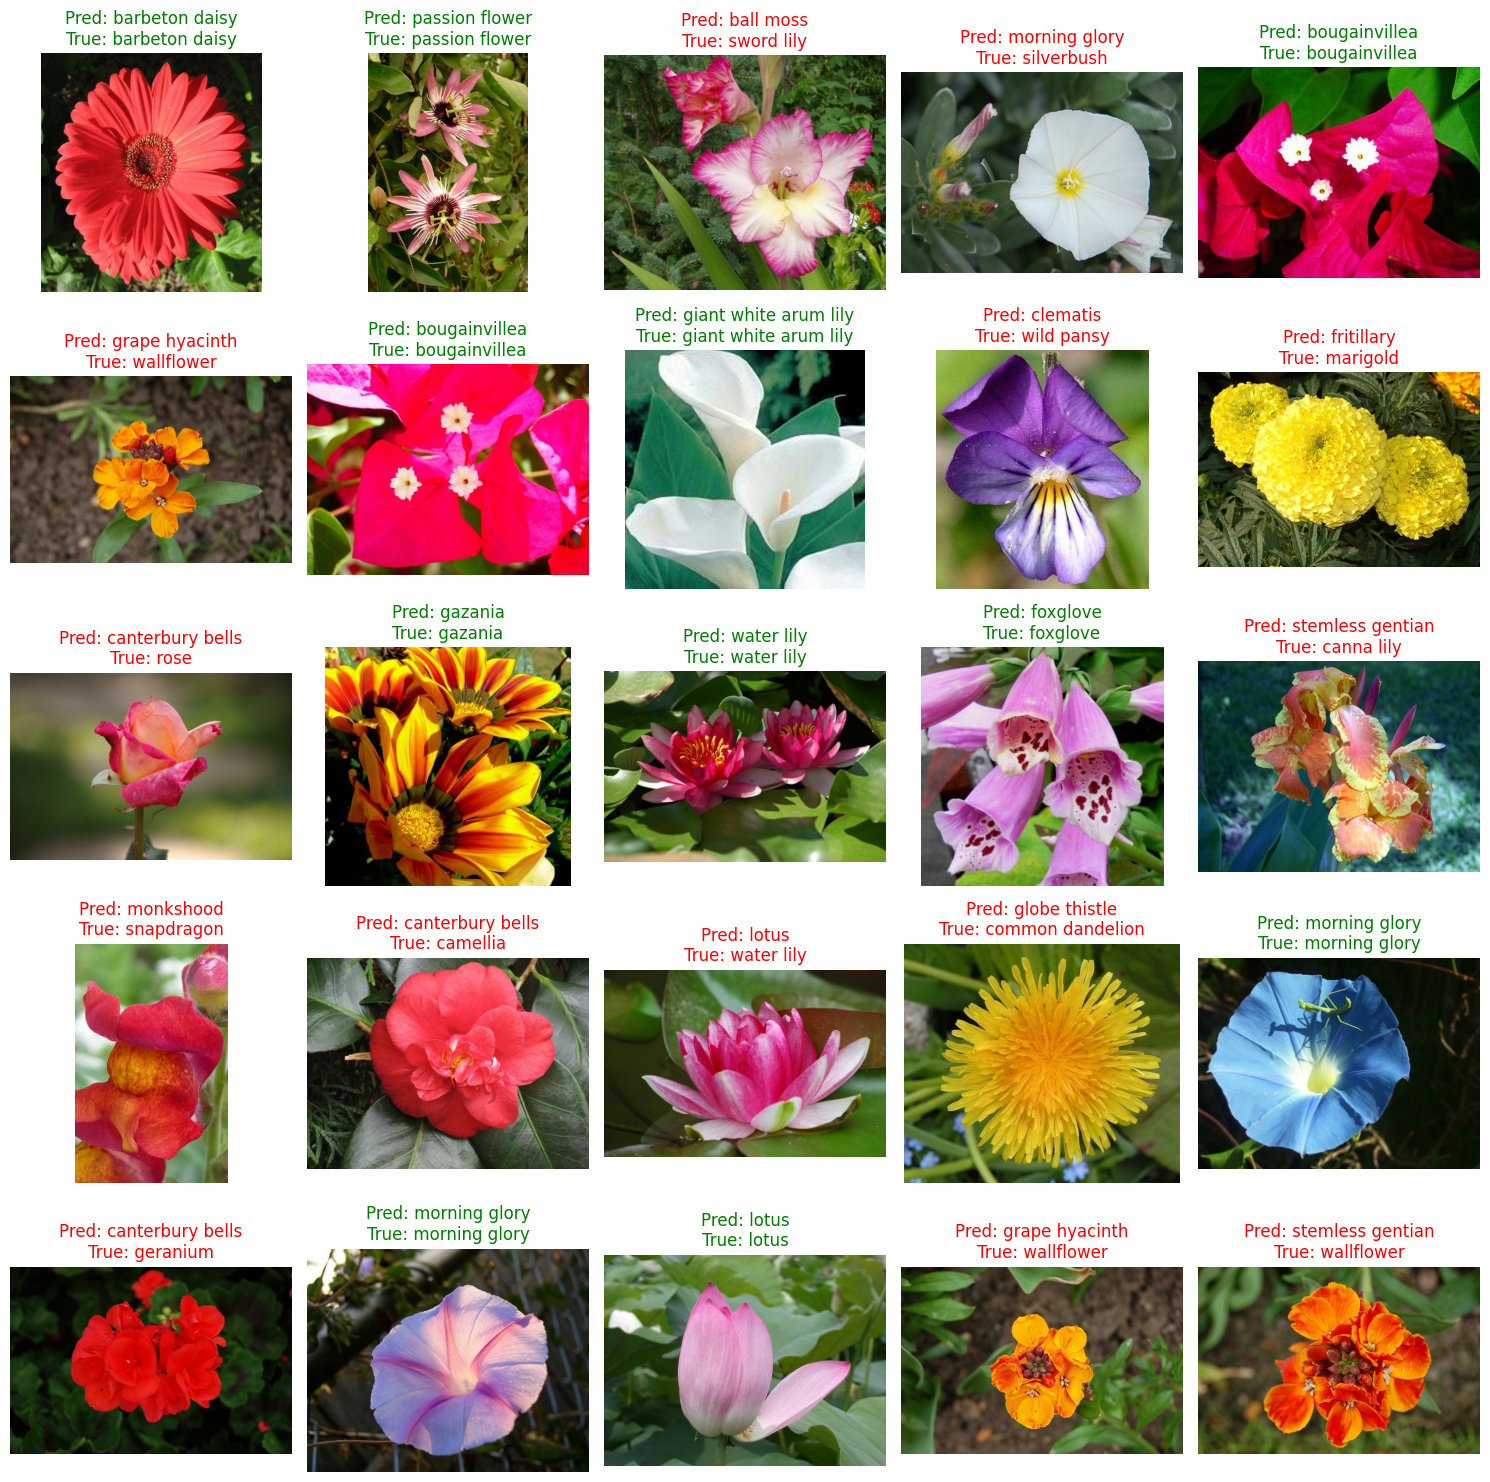

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Prepare Data for Visualization and Prediction

# Get the human-readable class names from the 'info' object
class_names = info.features['label'].names

# Define the preprocessing function needed for the model
def format_for_prediction(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Create a small dataset of 25 original images for visualization
vis_dataset = test_dataset.take(25)
pred_dataset = vis_dataset.map(format_for_prediction).batch(25)


#  Load the Best Model and Make Predictions

try:
    best_model = tf.keras.models.load_model('best_resnet_model.keras')

    # Get the predictions
    predictions = best_model.predict(pred_dataset)
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot the Results
    print("Visualizing model predictions (Correct = Green, Incorrect = Red)")
    plt.figure(figsize=(15, 15))

    # Iterate through the VISUALIZATION dataset (with original images)
    for i, (image, label) in enumerate(vis_dataset):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))

        true_label = label.numpy()
        predicted_class = class_names[predicted_labels[i]]
        true_class = class_names[true_label]

        title_color = "green" if predicted_labels[i] == true_label else "red"

        plt.title(f"Pred: {predicted_class}\nTrue: {true_class}", color=title_color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: 'best_resnet_model.keras' not found.")
    print("Please ensure you have run the training with callbacks to save the model.")
except Exception as e:
    print(f"An error occurred: {e}")


Here are 5 insights from the sample prediction visualization:

1.  **Correct Classifications:** Observe the images with green titles to see examples where the model correctly predicted the flower species.
2.  **Misclassifications:** Examine the images with red titles to identify which flower types the model struggled to classify correctly.
3.  **Visual Similarity:** For misclassifications, consider if the incorrect prediction is a flower species that is visually similar to the true label, suggesting potential challenges in distinguishing subtle differences.
4.  **Image Quality and Variety:** Note if certain image characteristics (e.g., lighting, angle, focus) seem to be associated with incorrect predictions.
5.  **Model Confidence (Implicit):** While not directly displayed, the presence of both correct and incorrect predictions gives an implicit sense of where the model is confident and where it is less certain. Analyzing the prediction probabilities (if added to the visualization) would provide explicit insight into confidence.